# FLI with compositional score matching


In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch

os.environ['KERAS_BACKEND'] = 'torch'
from bayesflow import diagnostics

from torch.utils.data import DataLoader

from diffusion_model import HierarchicalScoreModel, SDE, weighting_function, euler_maruyama_sampling, adaptive_sampling, \
    generate_diffusion_time, count_parameters, train_hierarchical_score_model
from problems.fli import FLIProblem, FLI_Prior, Simulator, generate_synthetic_data
from problems import plot_shrinkage, visualize_simulation_output

/Users/jonas.arruda/miniconda/envs/hierarchical-score-matching/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
DEBUG:cmdstanpy:found newer exe file, not recompiling


In [2]:
torch_device = torch.device("cpu")

In [3]:
prior = FLI_Prior()
simulator_test = Simulator()

In [4]:
batch_size = 128
max_number_of_obs = 1  # larger than one means we condition the score on multiple observations

dataset = FLIProblem(
    n_data=10000,
    prior=prior,
    online_learning=True,
    max_number_of_obs=max_number_of_obs,
)

dataset_valid = FLIProblem(
    n_data=batch_size*2,
    prior=prior,
    max_number_of_obs=max_number_of_obs,
)

# Create dataloader
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
dataloader_valid = DataLoader(dataset_valid, batch_size=batch_size, shuffle=False)

Moving prior to device: cpu


In [5]:
# Define diffusion model
current_sde = SDE(
    kernel_type=['variance_preserving', 'sub_variance_preserving'][0],
    noise_schedule=['linear', 'cosine', 'flow_matching'][1]
)

score_model = HierarchicalScoreModel(
    input_dim_theta_global=prior.n_params_global,
    input_dim_theta_local=prior.n_params_local,
    input_dim_x=1,
    hidden_dim=64,
    n_blocks=3,
    max_number_of_obs=max_number_of_obs,
    prediction_type=['score', 'e', 'x', 'v'][3],
    sde=current_sde,
    time_embed_dim=16,
    use_film=True,
    weighting_type=[None, 'likelihood_weighting', 'flow_matching', 'sigmoid'][1],
    prior=prior,
    name_prefix='FLI_'
)
print(score_model.name)
count_parameters(score_model)

# make dir for plots
if not os.path.exists(f"plots/{score_model.name}"):
    os.makedirs(f"plots/{score_model.name}")

Kernel type: variance_preserving, noise schedule: cosine
t_min: 0.00035210439818911254, t_max: 0.9957104921340942
alpha, sigma: (tensor(1.0000), tensor(0.0011)) (tensor(0.0134), tensor(0.9999))
FLI_hierarchical_score_model_v_variance_preserving_cosine_likelihood_weighting
+-----------------------------------------+------------+
|                 Modules                 | Parameters |
+-----------------------------------------+------------+
|         summary_net.weight_ih_l0        |    192     |
|         summary_net.weight_hh_l0        |   12288    |
|          summary_net.bias_ih_l0         |    192     |
|          summary_net.bias_hh_l0         |    192     |
|        global_model.embed.0.scale       |     1      |
|       global_model.embed.1.weight       |    256     |
|        global_model.embed.1.bias        |     16     |
|     global_model.input_layer.weight     |    384     |
|      global_model.input_layer.bias      |     64     |
|     global_model.blocks.0.fc.weight     |

In [ ]:
# train model
loss_history = train_hierarchical_score_model(score_model, dataloader, dataloader_valid=dataloader_valid,
                                              epochs=500, device=torch_device)
score_model.eval()
torch.save(score_model.state_dict(), f"models/{score_model.name}.pt")

# plot loss history
plt.figure(figsize=(6, 3), tight_layout=True)
plt.plot(loss_history[:, 0], label='Mean Train')
plt.plot(loss_history[:, 1], label='Mean Valid')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig(f'plots/{score_model.name}/loss_training.png')
plt.show()

In [6]:
score_model.load_state_dict(torch.load(f"models/{score_model.name}.pt", weights_only=True))
score_model.eval();

In [7]:
# check the error prediction: is it close to the noise?
loss_list_target = {}
loss_list_score = {}
loss_list_error_w_global = {}
loss_list_error_w_local = {}
loss_list_error = {}

with torch.no_grad():
    # Generate diffusion time and step size
    diffusion_time = generate_diffusion_time(size=100, device=torch_device)
    for t in diffusion_time:
        loss_list_target[t.item()] = 0
        loss_list_score[t.item()] = 0
        loss_list_error_w_global[t.item()] = 0
        loss_list_error_w_local[t.item()] = 0
        loss_list_error[t.item()] = 0

        for theta_global_batch, _, theta_local_batch, _, x_batch in dataloader_valid:
            theta_global_batch = theta_global_batch.to(torch_device)
            theta_local_batch = theta_local_batch.to(torch_device)
            x_batch = x_batch.to(torch_device)

            # sample from the Gaussian kernel, just learn the noise
            epsilon_global = torch.randn_like(theta_global_batch, dtype=torch.float32, device=torch_device)
            epsilon_local = torch.randn_like(theta_local_batch, dtype=torch.float32, device=torch_device)

            # perturb the theta batch
            t_tensor = torch.full((theta_global_batch.shape[0], 1), t,
                                  dtype=torch.float32, device=torch_device)
            # perturb the theta batch
            snr = score_model.sde.get_snr(t=t_tensor)
            alpha, sigma = score_model.sde.kernel(log_snr=snr)
            z_global = alpha * theta_global_batch + sigma * epsilon_global
            if score_model.max_number_of_obs > 1:
                # global params are not factorized to the same level as local params
                alpha_local = alpha.unsqueeze(1)
                sigma_local = sigma.unsqueeze(1)
            else:
                alpha_local = alpha
                sigma_local = sigma
            z_local = alpha_local * theta_local_batch + sigma_local * epsilon_local

            # predict from perturbed theta
            pred_epsilon_global, pred_epsilon_local = score_model(theta_global=z_global, theta_local=z_local,
                                       time=t_tensor, x=x_batch, pred_score=False)
            pred_score_global, pred_score_local = score_model(theta_global=z_global, theta_local=z_local,
                                     time=t_tensor, x=x_batch, pred_score=True)
            true_score_global = score_model.sde.grad_log_kernel(x=z_global,
                                                                x0=theta_global_batch, t=t_tensor)
            if score_model.max_number_of_obs == 1:
                true_score_local = score_model.sde.grad_log_kernel(x=z_local,
                                                                   x0=theta_local_batch,
                                                                   t=t_tensor)
            else:
                true_score_local = []
                for i in range(score_model.max_number_of_obs):
                    score_local = score_model.sde.grad_log_kernel(x=z_local[:, i],
                                                                   x0=theta_local_batch[:, i],
                                                                   t=t_tensor)
                    true_score_local.append(score_local.unsqueeze(1))
                true_score_local = torch.concatenate(true_score_local, dim=1)

            if score_model.prediction_type == 'score':
                target_global = -epsilon_global / sigma
                pred_target_global = -pred_epsilon_global / sigma
                target_local = -epsilon_local / sigma_local
                pred_target_local = -pred_epsilon_local / sigma_local
            elif score_model.prediction_type == 'e':
                target_global = epsilon_global
                pred_target_global = pred_epsilon_global
                target_local = epsilon_local
                pred_target_local = pred_epsilon_local
            elif score_model.prediction_type == 'v':
                target_global = alpha*epsilon_global - sigma * theta_global_batch
                pred_target_global = alpha*pred_epsilon_global - sigma * theta_global_batch
                target_local = alpha_local*epsilon_local - sigma_local * theta_local_batch
                pred_target_local = alpha_local*pred_epsilon_local - sigma_local * theta_local_batch
            elif score_model.prediction_type == 'x':
                target_global = theta_global_batch
                pred_target_global = (z_global - pred_epsilon_global * sigma) / alpha
                target_local = theta_local_batch
                pred_target_local = (z_local - pred_epsilon_local * sigma_local) / alpha_local
            else:
                raise ValueError("Invalid prediction type.")

            # calculate the loss (sum over the last dimension, mean over the batch)
            loss_global = torch.mean(torch.sum(torch.square(pred_target_global - target_global), dim=-1))
            loss_local = torch.mean(torch.sum(torch.square(pred_target_local - target_local), dim=-1))
            loss = loss_global + loss_local
            loss_list_target[t.item()] += loss.item()

            # calculate the error of the true score
            loss_global = torch.mean(torch.sum(torch.square(pred_score_global - true_score_global), dim=-1))
            loss_local = torch.mean(torch.sum(torch.square(pred_score_local - true_score_local), dim=-1))
            loss = loss_global + loss_local
            loss_list_score[t.item()] += loss.item()

            # calculate the weighted loss
            w = weighting_function(t_tensor, sde=score_model.sde,
                                   weighting_type=score_model.weighting_type, prediction_type=score_model.prediction_type)
            loss_global = torch.mean(w * torch.sum(torch.square(pred_epsilon_global - epsilon_global), dim=-1))
            loss_local = torch.mean(w * torch.sum(torch.square(pred_epsilon_local - epsilon_local), dim=-1))
            #loss = loss_global + loss_local
            loss_list_error_w_global[t.item()] += loss_global.item()
            loss_list_error_w_local[t.item()] += loss_local.item()

            # check if the weighting function is correct
            loss_global = torch.mean(torch.sum(torch.square(pred_epsilon_global - epsilon_global), dim=-1))
            loss_local = torch.mean(torch.sum(torch.square(pred_epsilon_local - epsilon_local), dim=-1))
            loss = loss_global + loss_local
            loss_list_error[t.item()] += loss.item()

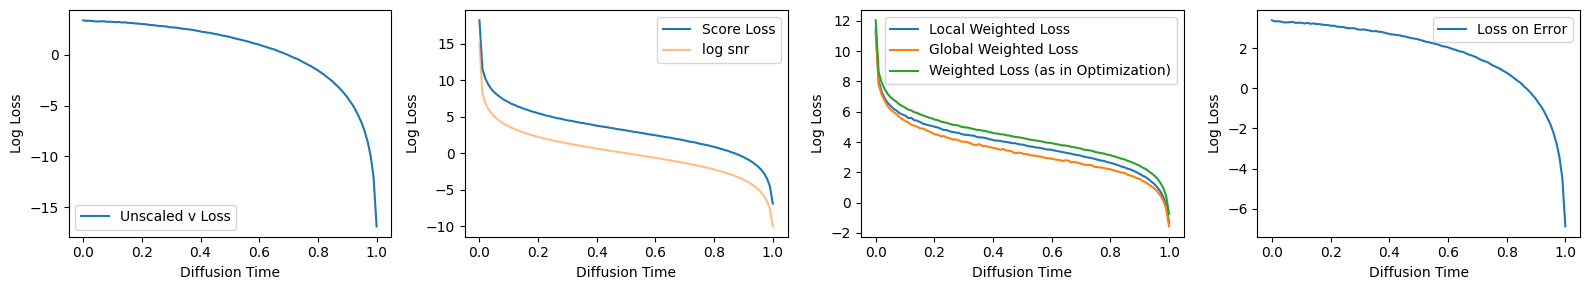

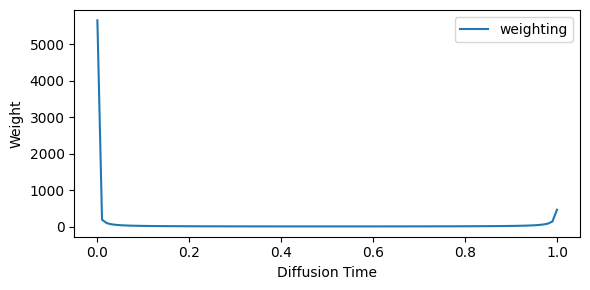

In [8]:
df_target = pd.DataFrame(loss_list_target.items(), columns=['Time', 'Loss'])
df_score = pd.DataFrame(loss_list_score.items(), columns=['Time', 'Loss'])
df_error_w_local = pd.DataFrame(loss_list_error_w_local.items(), columns=['Time', 'Loss'])
df_error_w_global = pd.DataFrame(loss_list_error_w_global.items(), columns=['Time', 'Loss'])
df_error = pd.DataFrame(loss_list_error.items(), columns=['Time', 'Loss'])

# compute snr
snr = score_model.sde.get_snr(diffusion_time)
#upper_bound_loss = (np.sqrt(2) + 1) / (std.numpy()**2)

fig, ax = plt.subplots(ncols=4, sharex=True, figsize=(16, 3), tight_layout=True)
ax[0].plot(df_target['Time'], np.log(df_target['Loss']), label=f'Unscaled {score_model.prediction_type} Loss')
ax[1].plot(df_score['Time'], np.log(df_score['Loss']), label='Score Loss')
#ax[1].plot(df_score['Time'], df_score['Loss'] / upper_bound_loss, label='Score Loss')
ax[1].plot(diffusion_time, snr, label='log snr', alpha=0.5)
ax[2].plot(df_error_w_local['Time'], np.log(df_error_w_local['Loss']), label='Local Weighted Loss')
ax[2].plot(df_error_w_global['Time'], np.log(df_error_w_global['Loss']), label='Global Weighted Loss')
ax[2].plot(df_error_w_local['Time'], np.log(df_error_w_local['Loss']+df_error_w_global['Loss']), label='Weighted Loss (as in Optimization)')
ax[3].plot(df_error['Time'], np.log(df_error['Loss']), label='Loss on Error')
for a in ax:
    a.set_xlabel('Diffusion Time')
    a.set_ylabel('Log Loss')
    a.legend()
plt.savefig(f'plots/{score_model.name}/losses_diffusion_time.png')
plt.show()

plt.figure(figsize=(6, 3), tight_layout=True)
plt.plot(diffusion_time.cpu(),
         weighting_function(diffusion_time, sde=score_model.sde, weighting_type=score_model.weighting_type,
                            prediction_type=score_model.prediction_type).cpu(),
         label='weighting')
plt.xlabel('Diffusion Time')
plt.ylabel('Weight')
plt.legend()
plt.show()

# Validation

In [16]:
n_grid = 4
valid_prior_global, valid_prior_local, valid_data = generate_synthetic_data(prior=prior, n_samples=100, n_local_samples=n_grid*n_grid,
                                                                            as_grid=True,
                                                                            random_seed=0)
n_post_samples = 20
global_param_names = prior.global_param_names
local_param_names = prior.get_local_param_names(n_grid*n_grid)
#score_model.current_number_of_obs = 4  # we can choose here, how many observations are passed together through the score

In [17]:
mini_batch_size = 10
t1_value = 0.1 #/( (n_grid*n_grid) //score_model.current_number_of_obs)
t0_value = 1
mini_batch_arg = {
    'size': mini_batch_size,
    #'damping_factor': lambda t: t1_value + (t0_value - t1_value) * 0.5 * (1 + torch.cos(torch.pi * t)),
    #'damping_factor': lambda t: t0_value + (t1_value - t0_value) * score_model.sde.kernel(log_snr=score_model.sde.get_snr(t))[1],
    #'damping_factor': lambda t: 0.1, #t1_value,
    'damping_factor': lambda t: t0_value * torch.exp(-np.log(t0_value / t1_value) * 2*t),
    'damping_factor_prior': lambda t: t0_value * torch.exp(-np.log(t0_value / t1_value) * 2*t),
    #'damping_factor': lambda t: t0_value + (t1_value - t0_value) * torch.sigmoid(20*(t-0.3))
}
#plt.plot(torch.linspace(0, 1, 100), mini_batch_arg['damping_factor'](torch.linspace(0, 1, 100)))
#plt.show()

t0_value, t1_value

(1, 0.1)

In [18]:
score_model.sde.s_shift_cosine = 2
posterior_global_samples_valid = adaptive_sampling(score_model, valid_data, n_post_samples,
                                                   mini_batch_arg=mini_batch_arg,
                                                   run_sampling_in_parallel=False,
                                                   device=torch_device, verbose=True)

  0%|          | 11/5000 [00:02<17:21,  4.79it/s]


Finished after 12 steps (24 score evals) at time 0.0.
Mean step size: 0.11111111017736322, min: 6.51188674964942e-05, max: 0.5


  0%|          | 14/5000 [00:02<16:21,  5.08it/s]


Finished after 15 steps (30 score evals) at time 0.0.
Mean step size: 0.08333333181993414, min: 0.003848483320325613, max: 0.5


  0%|          | 18/5000 [00:03<15:25,  5.39it/s]


Finished after 19 steps (38 score evals) at time 0.0.
Mean step size: 0.06249999749707058, min: 0.00749836303293705, max: 0.3246062397956848


  1%|          | 28/5000 [00:05<15:21,  5.40it/s]


Finished after 29 steps (58 score evals) at time 0.0.
Mean step size: 0.055555554371999785, min: 0.0008191693341359496, max: 0.5


  0%|          | 15/5000 [00:03<17:55,  4.63it/s]


Finished after 16 steps (32 score evals) at time 0.0.
Mean step size: 0.0769230801032301, min: 5.776378384325653e-05, max: 0.5


  1%|          | 28/5000 [00:05<16:50,  4.92it/s]


Finished after 29 steps (58 score evals) at time 0.0.
Mean step size: 0.04545454193033616, min: 0.0006928971270099282, max: 0.19280245900154114


  0%|          | 14/5000 [00:02<16:53,  4.92it/s]


Finished after 15 steps (30 score evals) at time 0.0.
Mean step size: 0.09090909178749743, min: 0.0017486492870375514, max: 0.5


  0%|          | 10/5000 [00:01<16:22,  5.08it/s]


Finished after 11 steps (22 score evals) at time 0.0.
Mean step size: 0.11111111186134319, min: 0.0016504463274031878, max: 0.5


  0%|          | 12/5000 [00:02<16:17,  5.10it/s]


Finished after 13 steps (26 score evals) at time 0.0.
Mean step size: 0.09999999904539436, min: 0.0022438073065131903, max: 0.5


  0%|          | 21/5000 [00:03<15:44,  5.27it/s]


Finished after 22 steps (44 score evals) at time 0.0.
Mean step size: 0.05555555511576434, min: 0.0070066796615719795, max: 0.34014949202537537


  0%|          | 17/5000 [00:03<16:12,  5.12it/s]


Finished after 18 steps (36 score evals) at time 0.0.
Mean step size: 0.07692307760365881, min: 0.0025090384297072887, max: 0.5


  0%|          | 14/5000 [00:02<16:45,  4.96it/s]


Finished after 15 steps (30 score evals) at time 0.0.
Mean step size: 0.09090908790345896, min: 0.005308312829583883, max: 0.5


  0%|          | 21/5000 [00:04<17:28,  4.75it/s]


Finished after 22 steps (44 score evals) at time 0.0.
Mean step size: 0.06250000211002771, min: 0.0018061315640807152, max: 0.21588915586471558


  0%|          | 10/5000 [00:01<16:28,  5.05it/s]


Finished after 11 steps (22 score evals) at time 0.0.
Mean step size: 0.11111110862758425, min: 0.015604335814714432, max: 0.5


  0%|          | 9/5000 [00:02<20:14,  4.11it/s]


Finished after 10 steps (20 score evals) at time 0.0.
Mean step size: 0.11111111173199283, min: 0.011594126001000404, max: 0.5


  0%|          | 11/5000 [00:02<16:30,  5.04it/s]


Finished after 12 steps (24 score evals) at time 0.0.
Mean step size: 0.11111111090415055, min: 0.018203163519501686, max: 0.5


  1%|          | 28/5000 [00:05<15:46,  5.25it/s]


Finished after 29 steps (58 score evals) at time 0.0.
Mean step size: 0.04545454492935361, min: 0.00043384332093410194, max: 0.179874986410141


  1%|          | 31/5000 [00:05<15:39,  5.29it/s]


Finished after 32 steps (64 score evals) at time 0.0.
Mean step size: 0.03999999936379026, min: 7.371649553533643e-05, max: 0.22780925035476685


  1%|          | 54/5000 [00:09<15:00,  5.49it/s]


Finished after 55 steps (110 score evals) at time 0.0.
Mean step size: 0.03125000098839337, min: 9.093913104152307e-05, max: 0.5


  0%|          | 19/5000 [00:04<17:57,  4.62it/s]

Finished after 20 steps (40 score evals) at time 0.0.
Mean step size: 0.05882353104157921, min: 0.0031120891217142344, max: 0.32948440313339233


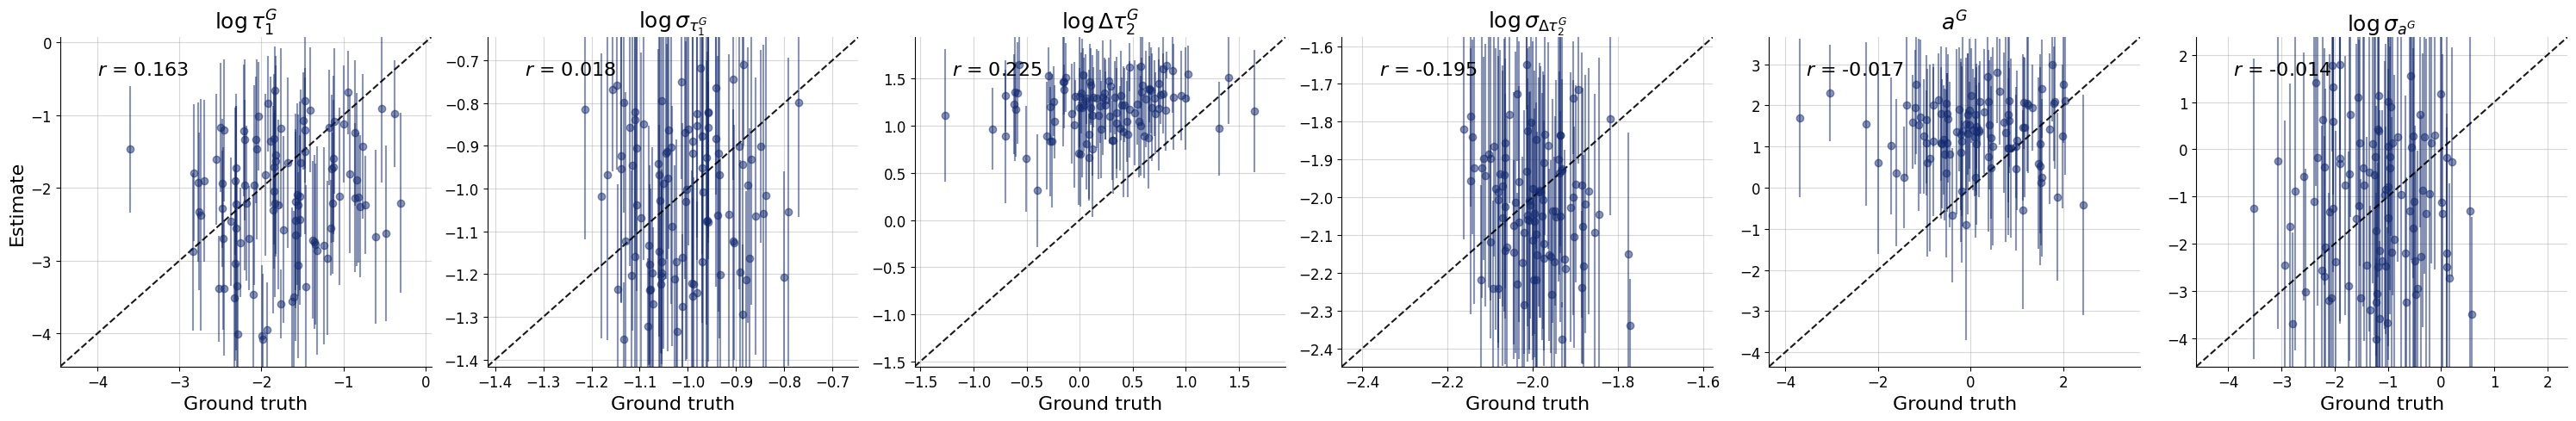

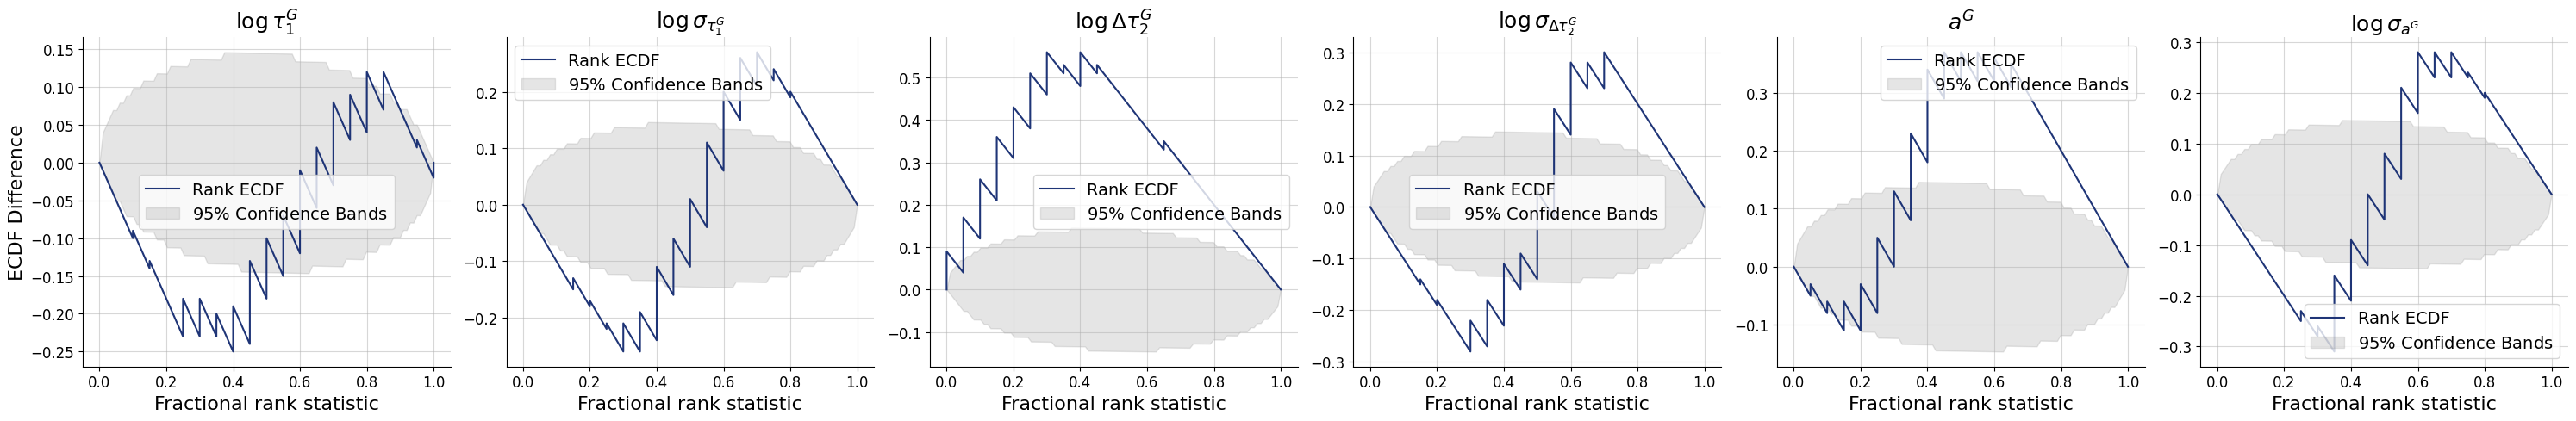

In [19]:
fig = diagnostics.recovery(posterior_global_samples_valid, np.array(valid_prior_global), variable_names=global_param_names)
fig.savefig(f'plots/{score_model.name}/recovery_global_adaptive_sampler.png')

fig = diagnostics.calibration_ecdf(posterior_global_samples_valid, np.array(valid_prior_global),
                          difference=True, variable_names=global_param_names)
fig.savefig(f'plots/{score_model.name}/ecdf_global_adaptive_sampler.png')

In [ ]:
conditions_global = (np.median(posterior_global_samples_valid, axis=0), posterior_global_samples_valid)[1]
score_model.sde.s_shift_cosine = 0
posterior_local_samples_valid = euler_maruyama_sampling(score_model, valid_data,
                                                        n_post_samples=n_post_samples, conditions=conditions_global,
                                                        diffusion_steps=50, device=torch_device, verbose=True)

 70%|███████   | 35/50 [01:52<00:33,  2.25s/it]

In [ ]:
diagnostics.recovery(posterior_local_samples_valid.reshape(valid_data.shape[0], n_post_samples, -1),
                          np.array(valid_prior_local).reshape(valid_data.shape[0], -1),
                          variable_names=local_param_names);

In [ ]:
plot_shrinkage(posterior_global_samples_valid, posterior_local_samples_valid)

In [ ]:
valid_id = 0
print('Data')
visualize_simulation_output(valid_data[valid_id])
print('Global Estimates')
print('mu:', np.median(posterior_global_samples_valid[valid_id, :, 0]), np.std(posterior_global_samples_valid[valid_id, :, 0]))
print('log sigma:', np.median(posterior_global_samples_valid[valid_id, :, 1]), np.std(posterior_global_samples_valid[valid_id, :, 1]))
print('True')
print('mu:', valid_prior_global[valid_id][0].item())
print('log sigma:', valid_prior_global[valid_id][1].item())

In [ ]:
med = np.median(posterior_local_samples_valid[valid_id].reshape(n_post_samples, n_grid, n_grid), axis=0)
std = np.std(posterior_local_samples_valid[valid_id].reshape(n_post_samples, n_grid, n_grid), axis=0)
error = (med-valid_prior_local[valid_id].numpy())**2
visualize_simulation_output(np.stack((med, valid_prior_local[valid_id], )),
                            title_prefix=['Posterior Median', 'True'])

visualize_simulation_output(np.stack((std, error)), title_prefix=['Uncertainty', 'Error'], same_scale=False)


plt.figure(figsize=(4, 4), tight_layout=True)
plt.errorbar(x=valid_prior_local[valid_id].flatten(), y=med.flatten(), yerr=1.96*std.flatten(), fmt='o')
plt.plot([np.min(med), np.max(med)], [np.min(med), np.max(med)], 'k--')
plt.axhline(np.median(posterior_global_samples_valid[valid_id, :], axis=0)[0], color='red', linestyle='--',
            label='Global posterior mean', alpha=0.75)
plt.ylabel('Prediction')
plt.xlabel('True')
plt.legend()
plt.show()